# **Image Super-Resolution**
**64x64 -> 512x512**

A colab notebook for upscaling 64x64 images to 512x512, using [this](https://github.com/Janspiry/Image-Super-Resolution-via-Iterative-Refinement).


## Setup
---
Instructions: 

*   Turn on hardware acceleration under `Runtime -> Change Runtime Type -> Hardware accelerator -> GPU`
*   Use this command to ensure that the connected machine has a GPU:

In [1]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla T4, 460.32.03, 15109 MiB


*    Now, execute each cell sequentially, waiting until each one is done before running the next cell.


### Clone repo, download a pre-trained model, install dependencies.


In [2]:
%cd /content/
!git clone https://github.com/Janspiry/Image-Super-Resolution-via-Iterative-Refinement.git
!pip install tensorboardx

/content
Cloning into 'Image-Super-Resolution-via-Iterative-Refinement'...
remote: Enumerating objects: 542, done.
remote: Counting objects: 100% (542/542), done.
remote: Compressing objects: 100% (358/358), done.
remote: Total 542 (delta 279), reused 412 (delta 169), pack-reused 0
Receiving objects: 100% (542/542), 10.00 MiB | 13.03 MiB/s, done.
Resolving deltas: 100% (279/279), done.
     |████████████████████████████████| 125 kB 25.1 MB/s 


Now for the download of the pre-trained model file.

Go to the [trained model location](https://drive.google.com/drive/folders/1mCiWhFqHyjt5zE4IdA41fjFwCYdqDzSF) in Google Drive, then right click on the first file and select "Add a shortcut to Drive". Then, choose whichever location to put it in your own Google Drive.

You can now connect this Colab section to your Drive to retrieve the file.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Change the path if you put it elsewhere

In [4]:
file_location = '/content/drive/MyDrive'

Execute to copy from the Drive to the Colab session

In [5]:
!cp {file_location}/I830000_E32_gen.pth /content/Image-Super-Resolution-via-Iterative-Refinement/

### Patch config files

Create patchfile



In [6]:
%%writefile 64_512.patch
--- sr_sr3_64_512_new.json	2021-10-22 16:20:20.901133618 +0000
+++ sr_sr3_64_512.json	2021-10-22 16:20:52.036081672 +0000
@@ -9,8 +9,8 @@
         "tb_logger": "tb_logger",
         "results": "results",
         "checkpoint": "checkpoint",
-        "resume_state": null
-        // "resume_state": "experiments/distributed_high_sr_ffhq_210901_121212/checkpoint/I830000_E32" //pretrain model or training state
+        // "resume_state": null
+        "resume_state": "I830000_E32" //pretrain model or training state
     },
     "datasets": {
         "train": {



Writing 64_512.patch


Apply patchfile

In [7]:
!apt-get install dos2unix
!dos2unix sr_sr3_64_512.json
!patch < 64_512.patch

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  dos2unix
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 351 kB of archives.
After this operation, 1,267 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 dos2unix amd64 7.3.4-3 [351 kB]
Fetched 351 kB in 1s (651 kB/s)
Selecting previously unselected package dos2unix.
(Reading database ... 155320 files and directories currently installed.)
Preparing to unpack .../dos2unix_7.3.4-3_amd64.deb ...
Unpacking dos2unix (7.3.4-3) ...
Setting up dos2unix (7.3.4-3) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
dos2unix: sr_sr3_64_512.json: No such file or directory
dos2unix: Skipping sr_sr3_64_512.json, not a regular file.
can't f

### Prepare Data
Upload 64x64 pixel image(s) to be upscaled

*Click the **browse** button and select the images you would like to upscale.*

Note that the image does not need to be 64x64 since it will be resized in a pre-processing step, however it is better to upload a square image in order to avoid a distorsion.

In [9]:
%cd /content/Image-Super-Resolution-via-Iterative-Refinement/
!mkdir -p input
%cd /content/Image-Super-Resolution-via-Iterative-Refinement/input/
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  savefile = open(fn, 'wb')
  savefile.write(uploaded[fn])
  print('Successfully uploaded "{}" ({} bytes).'.format(fn, len(uploaded[fn])))
  savefile.close()

/content/Image-Super-Resolution-via-Iterative-Refinement
/content/Image-Super-Resolution-via-Iterative-Refinement/input


Saving Poutine6cropped.jpg to Poutine6cropped.jpg
Successfully uploaded "Poutine6cropped.jpg" (45788 bytes).


Generate neccesary files and directory structure to begin upscaling.  

In [10]:
%cd /content/Image-Super-Resolution-via-Iterative-Refinement/
!python data/prepare_data.py --path /content/Image-Super-Resolution-via-Iterative-Refinement/input/ --size 64,512 --out ./dataset/celebahq

/content/Image-Super-Resolution-via-Iterative-Refinement
0/1 images processed/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:405: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
0/1 images processed 

## Upscaling
---
Note that this may take ~30 minutes or more, depending on which GPU you get.

Output images will be located under ./experiments/\<some folder\>/results

Installing wandb on the Colab machine (by default it is not installed)

In [11]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 24.9 MB/s 
     |████████████████████████████████| 181 kB 64.4 MB/s 
     |████████████████████████████████| 144 kB 75.2 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=cfdeb220e3c24422ed74624cc5ff8e1626d657b6fd42e7029be2c5244ac30594
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [12]:
!python infer.py -c /content/Image-Super-Resolution-via-Iterative-Refinement/config/sr_sr3_64_512.json

export CUDA_VISIBLE_DEVICES=0,1
22-03-01 12:51:09.104 - INFO:   name: distributed_high_sr_ffhq
  phase: val
  gpu_ids: [0, 1]
  path:[
    log: experiments/distributed_high_sr_ffhq_220301_125109/logs
    tb_logger: experiments/distributed_high_sr_ffhq_220301_125109/tb_logger
    results: experiments/distributed_high_sr_ffhq_220301_125109/results
    checkpoint: experiments/distributed_high_sr_ffhq_220301_125109/checkpoint
    resume_state: None
    experiments_root: experiments/distributed_high_sr_ffhq_220301_125109
  ]
  datasets:[
    train:[
      name: FFHQ
      mode: HR
      dataroot: dataset/ffhq_64_512
      datatype: img
      l_resolution: 64
      r_resolution: 512
      batch_size: 2
      num_workers: 8
      use_shuffle: True
      data_len: -1
    ]
    val:[
      name: CelebaHQ
      mode: LRHR
      dataroot: dataset/celebahq_64_512
      datatype: img
      l_resolution: 64
      r_resolution: 512
      data_len: 50
    ]
  ]
  model:[
    which_model_G: sr3
    fin

Let us now visualize the results !

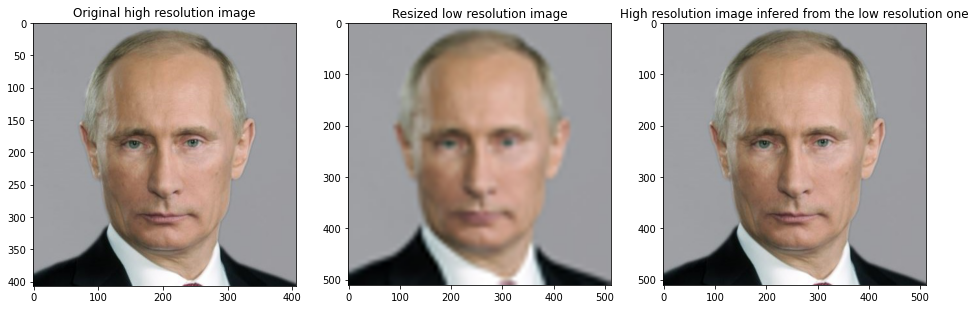

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

original = plt.imread('input/Poutine6cropped.jpg')
downsized = plt.imread('experiments/distributed_high_sr_ffhq_220301_125109/results/0_5_inf.png')
infered = plt.imread('experiments/distributed_high_sr_ffhq_220301_125109/results/0_5_hr.png')

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.imshow(original)
plt.title('Original high resolution image')
plt.subplot(132)
plt.imshow(downsized)
plt.title('Resized low resolution image')
plt.subplot(133)
plt.imshow(infered)
plt.title('High resolution image infered from the low resolution one')
plt.show()